In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.plotly as py
import plotly

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib.ticker import FuncFormatter
from pandas_datareader import data as pdr
from time import gmtime, strftime
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)
pd.set_option("display.max_rows", 20)

# Set matplotlib style
plt.style.use('seaborn')

# Set plotly offline
init_notebook_mode(connected=True)

In [3]:
%%capture
import cufflinks as cf
cf.go_offline()

In [4]:
a = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('A última vez que este script foi executado foi em:', a)

A última vez que este script foi executado foi em: 2017-12-05 23:25:29


In [5]:
#### Functions ####
def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min().abs()

def compute_cagr(dataframe, years=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)

def compute_romad(dataframe):
    '''
    Function to calculate RoMaD: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_performance_table(dataframe, years='si', freq='days'):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.    
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365.25
        
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD']
        return round(df, 2)        
    
    else:
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD']
        return round(df, 2)

def filter_by_date(dataframe, years=0, previous_row=False):
    
    last_date = fundos.tail(1).index
    year_nr = last_date.year.values[0]
    month_nr = last_date.month.values[0]
    day_nr = last_date.day.values[0]
            
    new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr)
    
    if previous_row == False:
        return dataframe.loc[new_date:]
    
    elif previous_row == True:
        return pd.concat([dataframe.loc[:new_date].tail(1), dataframe.loc[new_date:]])

In [6]:
# Downloading funds and creating quotes and returns dataframes
Begin = "2004-02-23"
# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

MSid = ['F00000MQHY', 'F0GBR04UGX']
Nomes = ['Mirabaud_CHF', 'MFS_ESC']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

# Filtering dataframe from Begin to END
# fundos = fundos.loc[:End] # Só activas se quiseres que acabe num dia especifíco

In [7]:
#### Returns ####
returns = (fundos / fundos.shift(1)) - 1

In [8]:
#### Normalization to 100 ####
fundos_norm = (fundos / fundos.iloc[0] * 100)

In [9]:
round(fundos_norm, 2).iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance dos fundos', logy=True)

In [10]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(fundos_norm), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios', yTitle='Percentagem')

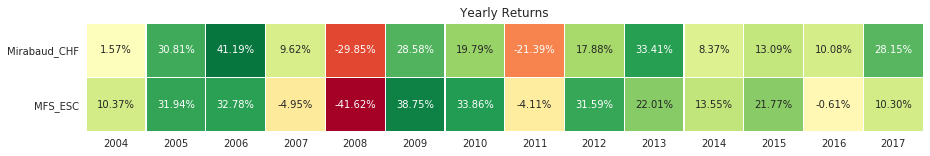

In [11]:
# Resampling to yearly (business year)
yearly_quotes = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([fundos_norm.iloc[:1], yearly_quotes])

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
returns = yearly_returns.set_index([list(range(2003, 2018))]).drop(2003)
returns.columns = Nomes

#### Inverter o sentido das rows no dataframe ####
returns = returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(15, 2) # 68%
heatmap = sns.heatmap(returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()

In [12]:
compute_performance_table(fundos_norm)

,Mirabaud_CHF,MFS_ESC
CAGR,11.97,11.80
StdDev,15.15,15.03
Sharpe,0.79,0.79
Max DD,49.17,56.22


In [13]:
# Incluir o Mirabaud_EUR
Mirabaud_EUR = round(pd.read_csv('Mirabaud_EUR.csv', sep=',',  parse_dates=True, header=None), 2)
Mirabaud_EUR.columns = ['date', 'Mirabaud_EUR']
Mirabaud_EUR.set_index(Mirabaud_EUR['date'], inplace=True)
Mirabaud_EUR = Mirabaud_EUR[['Mirabaud_EUR']]
fundos = fundos.merge(Mirabaud_EUR, left_index = True, right_index = True, how='inner')

In [14]:
#### Normalization to 100 ####
fundos_norm = (fundos / fundos.iloc[0] * 100)
fundos_norm.columns = ['Mirabaud_CHF', 'MFS_ESC', 'Mirabaud_EUR']

In [15]:
fundos_norm.iplot(logy=True)

In [16]:
compute_performance_table(fundos_norm)

,Mirabaud_CHF,MFS_ESC,Mirabaud_EUR
CAGR,11.97,11.80,14.45
StdDev,15.47,15.38,14.49
Sharpe,0.77,0.77,1.00
Max DD,49.17,56.22,42.56


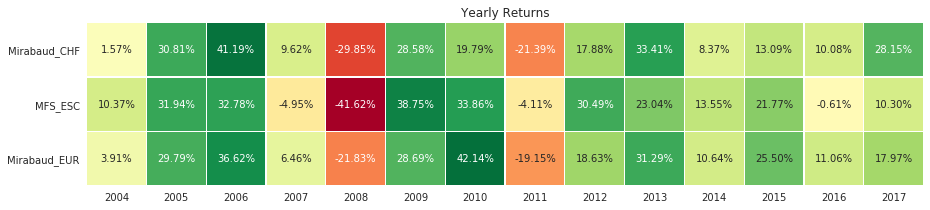

In [17]:
# Resampling to yearly (business year)
yearly_quotes = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([fundos_norm.iloc[:1], yearly_quotes])

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
returns = yearly_returns.set_index([list(range(2003, 2018))]).drop(2003)
returns.columns = fundos_norm.columns

#### Inverter o sentido das rows no dataframe ####
returns = returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(15, 3) # 68%
heatmap = sns.heatmap(returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()